In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultilabelClassifier(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.model_wo_fc = nn.Sequential(*(list(self.resnet.children())[:-1]))
        self.imageClass = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=512, out_features=n_features)
        )

    def forward(self, x):
        x = self.model_wo_fc(x)
        x = torch.flatten(x, 1)
        return {'class': self.imageClass(x)}


C:\Users\karti\AppData\Local\Temp\ipykernel_11892\2213445934.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("D:/COLLEGE_STUDIES/SEM-6/ML_NLP_pr

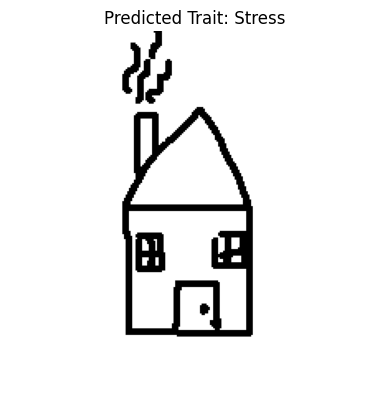

## 🧠 **Psychological Report:**
Signs of anxiety are visible in the artwork.

Text(value='', placeholder='Ask about the psychological report...')

Output()

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import random
import ipywidgets as widgets
from IPython.display import display, Markdown
from transformers import AutoModelForCausalLM, AutoTokenizer

# Define the model architecture (ResNet-34)
model = models.resnet34(pretrained=False)  # Ensure it matches your trained model

# Adjust final layer (assuming 3 classes: Stress, Introvert, Extrovert)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)  # Ensure it matches training

# Load trained model weights
checkpoint = torch.load("D:/COLLEGE_STUDIES/SEM-6/ML_NLP_project/model/house/house_model_10.tar", 
                        map_location=torch.device("cpu"))

# Define the model architecture
model = MultilabelClassifier(3).to("cpu")  # Initialize the model

# Load the checkpoint
checkpoint = torch.load("D:\COLLEGE_STUDIES\SEM-6\ML_NLP_project\model\house\house_model_10.tar", map_location="cpu")

# Load the model weights
model.load_state_dict(checkpoint["model_state_dict"])

# Set to evaluation mode
model.eval()


# Define image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Class Labels
class_labels = {0: "Stress", 1: "Introvert", 2: "Extrovert"}

# Load Chatbot model
model_name = "microsoft/DialoGPT-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
chatbot_model = AutoModelForCausalLM.from_pretrained(model_name)

# Function to classify an image
def classify_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(image_tensor)  # output is a dictionary
        predicted_class = torch.argmax(output['class'], dim=1).item()  # Extract tensor from dict

    return class_labels[predicted_class], image


# Function to generate chatbot responses
def chatbot_response(user_input):
    inputs = tokenizer.encode(user_input + tokenizer.eos_token, return_tensors="pt")
    output = chatbot_model.generate(inputs, max_length=100, pad_token_id=tokenizer.eos_token_id)
    response = tokenizer.decode(output[:, inputs.shape[-1]:][0], skip_special_tokens=True)
    return response

# Psychological reports
psych_reports = {
    "Stress": ["This drawing suggests emotional distress.", "Signs of anxiety are visible in the artwork."],
    "Introvert": ["The drawing indicates introverted tendencies.", "There is a pattern of shyness."],
    "Extrovert": ["This drawing suggests high energy.", "The artist appears confident and expressive."]
}

# Upload and classify image
image_path = r"D:\COLLEGE_STUDIES\SEM-6\ML_NLP_project\images\house\0.png"
trait, img = classify_image(image_path)


# Generate a psychological report
report = random.choice(psych_reports[trait])

# Display Image and Prediction
plt.imshow(img)
plt.axis("off")
plt.title(f"Predicted Trait: {trait}")
plt.show()

# Display Report
display(Markdown(f"## 🧠 **Psychological Report:**\n{report}"))

# Create Chat UI
chat_input = widgets.Text(placeholder="Ask about the psychological report...")
chat_output = widgets.Output()

# Function to handle user input
def on_chat_submit(change):
    with chat_output:
        print(f"👤 User: {change.new}")
        bot_reply = chatbot_response(change.new)
        print(f"🤖 Chatbot: {bot_reply}\n")

chat_input.observe(on_chat_submit, names='value')

# Show Chat UI
display(chat_input, chat_output)


In [ ]:
from sentence_transformers import SentenceTransformer, util

# Load pre-trained Sentence Transformer model
bert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Define psychological knowledge base
knowledge_base = {
    "Why is my drawing classified as stress?": 
        "Your drawing contains elements associated with psychological distress, such as heavy strokes, excessive shading, and chaotic patterns.",
    
    "How can I reduce stress in my drawings?": 
        "Using lighter strokes, drawing open spaces, and avoiding aggressive lines can help create a calmer representation in your artwork.",
    
    "What does an introverted drawing look like?": 
        "Introverted drawings tend to have smaller objects, minimal detailing, and often show isolated figures.",
    
    "Why is my drawing classified as extrovert?": 
        "Extroverted drawings typically use bright colors, large figures, and exaggerated expressions."
}

# Encode the knowledge base for similarity matching
knowledge_keys = list(knowledge_base.keys())
knowledge_embeddings = bert_model.encode(knowledge_keys, convert_to_tensor=True)


In [ ]:
def chatbot_reasoning(user_query):
    # Encode user query
    user_embedding = bert_model.encode(user_query, convert_to_tensor=True)

    # Find the closest question in the knowledge base
    similarity_scores = util.pytorch_cos_sim(user_embedding, knowledge_embeddings)[0]
    best_match_idx = similarity_scores.argmax().item()
    
    # Get the most relevant response
    best_match_question = knowledge_keys[best_match_idx]
    response = knowledge_base[best_match_question]
    
    return f"🤖 Chatbot: {response}"

# Example usage
user_question = "Why is my drawing classified as stress?"
print(chatbot_reasoning(user_question))


In [ ]:
import ipywidgets as widgets
from IPython.display import display, Markdown

# Create chat input and output
chat_input = widgets.Text(placeholder="Ask about the psychological report...")
chat_output = widgets.Output()

# Function to handle user input
def on_chat_submit(change):
    with chat_output:
        print(f"👤 User: {change.new}")
        bot_reply = chatbot_reasoning(change.new)
        print(f"{bot_reply}\n")

chat_input.observe(on_chat_submit, names='value')

# Display chat interface
display(chat_input, chat_output)
